In [20]:
from IPython.core.display import HTML
display(HTML('<style>.container { width:95% !important; } </style>'))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import numpy as np
from scipy.stats import binom, norm
from scipy.stats import jarque_bera, normaltest, shapiro
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

### Setup

In [22]:
SEED = 1234
rng = np.random.default_rng(SEED)

### Tests

In [23]:
def simple_normality_test(sample, delta, mu, sigma):
    """Test based on normal quantiles, mean and variance are known.
    """
    n = len(sample)
    Z = np.sqrt(n) * (np.mean(sample) - mu) / sigma
    q = -norm.ppf(delta / 2)
    
    return Z >= -q and Z <= q


def jb_normality_test(sample, delta, mu, sigma):
    """Jarque-Bera test.
    """
    p = jarque_bera(sample).pvalue 
    return p >= delta


def sw_normality_test(sample, delta, mu, sigma):
    """Shapiro-Wilk test.
    """
    p = shapiro(sample).pvalue 
    return p >= delta


def dp_normality_test(sample, delta, mu, sigma):
    """D'Agostino-Pearson test.
    """
    p = normaltest(sample).pvalue 
    return p >= delta

### Generate samples

In [85]:
def contaminate_sample(samples, fraction, mu=0.0, sigma=1.0, df=6):
    """Replace fraction% of the samples with samples from a heavier tailed (Student's) distribution
    with degree of freedom df.
    """
    shape = samples.shape
    samples = samples.flatten()
    n = int(fraction * len(samples))
    idx = rng.permutation(len(samples))
    # Rescale so that variance is also sigma
    samples[idx[:n]] = mu + sigma * np.sqrt((df - 2) / df) * rng.standard_t(df, size=n)
    return samples.reshape(shape), idx[:n]


mu = 0.0
sigma = 1.0

fraction = 0.01
df = 6

N = int(1e2)
M = int(1e4)

samples, idx_contamination = contaminate_sample(rng.normal(loc=mu, scale=sigma, size=N * M).reshape(M, N), fraction, mu=mu, sigma=sigma, df=df)

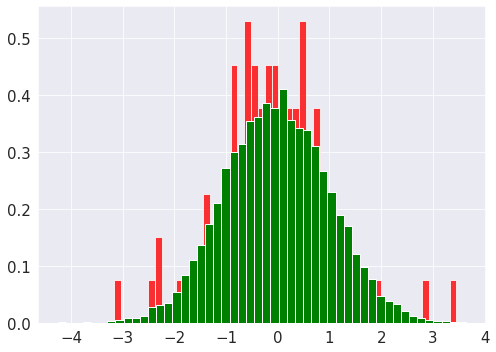

In [86]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)
    
    n_plot = int(1e4)
    ax.hist(samples.flatten()[idx_contamination[:int(fraction * n_plot)]], bins=50, alpha=0.8, color="red", density=True)
    ax.hist(samples.flatten()[:n_plot], bins=50, color="green", density=True)
    
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    plt.tight_layout()
    plt.show()

In [87]:
delta = 0.05
print("Type I error: rejecting the null (sample not normal) given that it is true (sample ~ normal).")
print("Type II error: failure to reject the null (sample ~ normal) given that it is false (sample not normal).\n")
print("Simple: {:.1%} of normality tests passed (theory if null holds: {:.0%})".format(np.mean([simple_normality_test(sample, delta, mu, sigma) for sample in samples]), 1 - delta,))
print("DP: {:.1%} of normality tests passed (theory if null holds: {:.0%})".format(np.mean([dp_normality_test(sample, delta, mu, sigma) for sample in samples]), 1 - delta))
print("JB: {:.1%} of normality tests passed (theory if null holds: {:.0%})".format(np.mean([jb_normality_test(sample, delta, mu, sigma) for sample in samples]), 1 - delta))
print("SW: {:.1%} of normality tests passed (theory if null holds: {:.0%})".format(np.mean([sw_normality_test(sample, delta, mu, sigma) for sample in samples]), 1 - delta))

Type I error: rejecting the null (sample not normal) given that it is true (sample ~ normal).
Type II error: failure to reject the null (sample ~ normal) given that it is false (sample not normal).

Simple: 94.0% of normality tests passed (theory if null holds: 95%)
DP: 83.0% of normality tests passed (theory if null holds: 95%)
JB: 83.0% of normality tests passed (theory if null holds: 95%)
SW: 85.0% of normality tests passed (theory if null holds: 95%)


/home/sauxpa/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [96]:
Ns = list(range(50, 10000, 50))
M = int(1e3)
n_passed_simple = []
n_passed_dp = []
n_passed_jb = []
n_passed_sw = []

for N in tqdm(Ns):
    samples, idx_contamination = contaminate_sample(rng.normal(loc=mu, scale=sigma, size=N * M).reshape(M, N), fraction, mu=mu, sigma=sigma, df=df)
    n_passed_simple.append(np.mean([simple_normality_test(sample, delta, mu, sigma) for sample in samples]))
    n_passed_dp.append(np.mean([dp_normality_test(sample, delta, mu, sigma) for sample in samples]))
    n_passed_jb.append(np.mean([jb_normality_test(sample, delta, mu, sigma) for sample in samples]))
    n_passed_sw.append(np.mean([sw_normality_test(sample, delta, mu, sigma) for sample in samples]))

  0%|          | 0/199 [00:00<?, ?it/s]

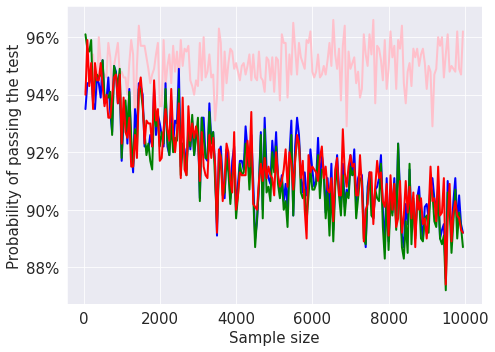

In [97]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)
    
    ax.plot(Ns, n_passed_simple, linewidth=2, color='pink', label='simple')
    ax.plot(Ns, n_passed_dp, linewidth=2, color='blue', label='DP')
    ax.plot(Ns, n_passed_jb, linewidth=2, color='green', label='JB')
    ax.plot(Ns, n_passed_sw, linewidth=2, color='red', label='SW')
    
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    ax.set_xlabel("Sample size", fontsize="15")
    ax.set_ylabel("Probability of passing the test", fontsize="15")
    ax.yaxis.set_major_formatter(lambda y, _: '{:.0%}'.format(y)) 

    plt.tight_layout()
    plt.show()

## Boundary crossing

In [ ]:
N = int(1e2)
M = int(1e4)

samples, idx_contamination = contaminate_sample(rng.normal(loc=mu, scale=sigma, size=N * M).reshape(M, N), fraction, mu=mu, sigma=sigma, df=df)

In [8]:
def get_all_probas(samples, delta, mu=0.0, sigma=1.0, test=simple_normality_test):
    q = -norm.ppf(delta / 2)
    threshs = np.linspace(0, 2 * q / np.sqrt(N), 50)
    crossings_cond = []
    crossings_uncond = []
    probas = []
    for sample in tqdm(samples):
        crossings_uncond_ = []
        mu_hat = np.mean(sample)

        for thresh in threshs:
            crossings_uncond_.append((mu_hat - mu) / sigma > thresh)
        crossings_uncond.append(crossings_uncond_)
        
        if test(sample, delta, mu, sigma):
            crossings_cond_ = []
            for thresh in threshs:
                crossings_cond_.append((mu_hat - mu) / sigma > thresh)
            crossings_cond.append(crossings_cond_)

    crossings_uncond = np.array(crossings_uncond)
    crossing_uncond_proba = crossings_uncond.mean(axis=0)
    crossing_uncond_proba_th = 1 - norm.cdf(np.sqrt(N) * threshs)
    
    crossings_cond = np.array(crossings_cond)
    crossing_cond_proba = crossings_cond.mean(axis=0)
    crossing_cond_proba_th = (1 / (1 - delta) * (1 - delta / 2 - norm.cdf(np.sqrt(N) * threshs))) * (np.sqrt(N) * threshs <= q)

    crossing_uncond_proba_lo = crossing_uncond_proba.copy()
    crossing_uncond_proba_hi = crossing_uncond_proba.copy()

    crossing_cond_proba_lo = crossing_cond_proba.copy()
    crossing_cond_proba_hi = crossing_cond_proba.copy()

    for i in range(len(threshs)):
        # Exact binomial CI
        crossing_uncond_proba_lo[i] = binom(len(crossings_uncond[:, i]), crossing_uncond_proba[i]).ppf(0.025) / len(crossings_uncond[:, i])
        crossing_uncond_proba_hi[i] = binom(len(crossings_uncond[:, i]), crossing_uncond_proba[i]).ppf(0.975) / len(crossings_uncond[:, i])
        crossing_cond_proba_lo[i] = binom(len(crossings_cond[:, i]), crossing_cond_proba[i]).ppf(0.025) / len(crossings_cond[:, i])
        crossing_cond_proba_hi[i] = binom(len(crossings_cond[:, i]), crossing_cond_proba[i]).ppf(0.975) / len(crossings_cond[:, i])

    return (
        threshs, 
        crossing_uncond_proba, crossing_uncond_proba_th, 
        crossing_cond_proba, crossing_cond_proba_th, 
        crossing_uncond_proba_lo, crossing_uncond_proba_hi, 
        crossing_cond_proba_lo, crossing_cond_proba_hi,
    )

In [9]:
def do_plot(delta, mu=0.0, sigma=1.0, test=simple_normality_test, do_th=True):
    rets = get_all_probas(samples, delta, mu, sigma, test=test)
    
    threshs = rets[0]
    crossing_uncond_proba = rets[1]
    crossing_uncond_proba_th = rets[2]
    crossing_cond_proba = rets[3]
    crossing_cond_proba_th = rets[4]
    crossing_uncond_proba_lo = rets[5]
    crossing_uncond_proba_hi = rets[6]
    crossing_cond_proba_lo = rets[7]
    crossing_cond_proba_hi = rets[8]
    
    with sns.axes_style("darkgrid"):
        fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)

        ax.plot(threshs, crossing_uncond_proba, color="blue", linewidth=2, label="Unconditional (empirical)")
        ax.plot(threshs, crossing_cond_proba, color="red", linewidth=2, label="Conditional (empirical)")

        ax.fill_between(threshs, y1=crossing_uncond_proba_lo, y2=crossing_uncond_proba_hi, alpha=0.1, color="blue")
        ax.fill_between(threshs, y1=crossing_cond_proba_lo, y2=crossing_cond_proba_hi, alpha=0.1, color="red")

        if do_th:
            ax.plot(threshs, crossing_uncond_proba_th, color="blue", linestyle="dashed", linewidth=2, label="Unconditional (theoretical)")
            ax.plot(threshs, crossing_cond_proba_th, color="red", linestyle="dashed", linewidth=2, label="Conditional (theoretical)")
        
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        ax.set_xlabel("Threshold", fontsize="15")
        ax.set_ylabel("Crossing probability", fontsize="15")
        ax.yaxis.set_major_formatter(lambda y, _: '{:.0%}'.format(y))
        ax.set_title("$\delta=${:.0%}".format(delta), fontsize="15")
        ax.legend(loc="upper right", prop={"size": 14})

        plt.tight_layout()
        plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

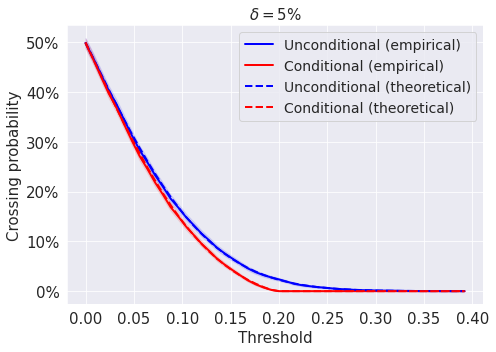

In [10]:
do_plot(0.05, mu=mu, sigma=sigma, test=simple_normality_test)

  0%|          | 0/10000 [00:00<?, ?it/s]

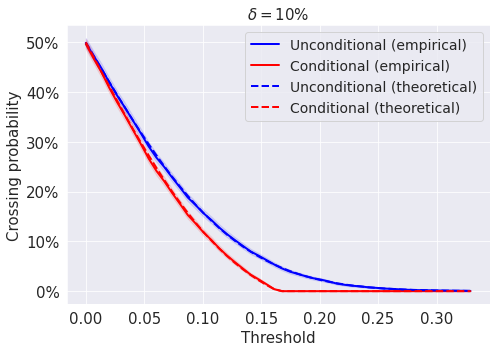

In [11]:
do_plot(0.1, mu=mu, sigma=sigma, test=simple_normality_test)

  0%|          | 0/10000 [00:00<?, ?it/s]

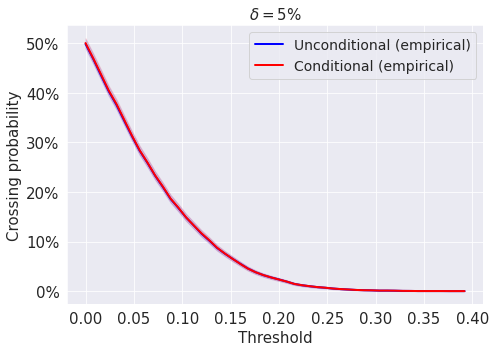

In [12]:
do_plot(0.05, mu=mu, sigma=sigma, test=jb_normality_test, do_th=False)

  0%|          | 0/10000 [00:00<?, ?it/s]

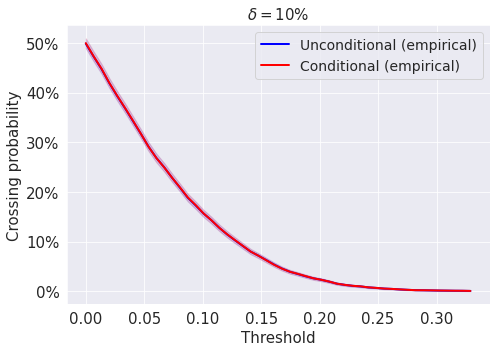

In [13]:
do_plot(0.1, mu=mu, sigma=sigma, test=jb_normality_test, do_th=False)